In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tic_env import TictactoeEnv, OptimalPlayer

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque 
from random import random, sample, randint

In [114]:
def valid_move(grid, move):
    return grid[(move//3,move%3)] == 0

class DeepQLearner:

    def __init__(self, network, replayBuffer, epsilon=0.1):
        self.epsilon=epsilon
        
        self.model = network
        self.replayBuffer =  replayBuffer 
        self.last_state = None
        self.last_action = None
            
    
    def act(self, grid):
        move = self._act_random(grid) if random()<self.epsilon else self._act_optimal(grid)
        
        self.push(grid,0)
        self.last_state = grid
        self.last_action = move
        return move
    
    
    def update_epsilon(self, new_epsilon):
        self.epsilon = new_epsilon
    
    def _act_optimal(self, grid):
        with torch.no_grad():
            actions_reward = self.model(grid_to_state(grid))
            return torch.argmax(actions_reward).item()
        
        
    def _act_random(self, grid):
        actions = [i for i in range(9) if valid_move(grid,i)]
        return actions[randint(0,len(actions)-1)]
    
    def update_qvalue_end(self, reward=0):
        ### shall we add the end state
        self.push(None, reward)
    
    def push(self, state, reward):
        if self.last_action is not None and self.last_state is not None:
            self.replayBuffer.push( self.last_state, self.last_action, state, reward)

def network():
    return nn.Sequential(nn.Linear(9*2,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,128),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(128,9))

def grid_to_state(grid):
    return torch.tensor(np.stack([grid>0,grid<0])).float().view(1,-1)

#######from pytroch tutorial
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [27]:
env = TictactoeEnv()
env.step(0)
grid,_,_ = env.step(1)
grid

array([[ 1., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [28]:
grid_to_state(grid)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [175]:
def train_deep_q_player(optimal_epsilon=0.5, update_length = 500, average_length = 250.0):
    Turns = np.array(['X','O'])
    
    policy_net = network()
    target_net = network()
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    replayBuffer = ReplayMemory(10000)
    
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
    criterion = nn.HuberLoss()
    
    deep_q = DeepQLearner(policy_net, replayBuffer, epsilon=0.8)
    optimal = OptimalPlayer(epsilon=0.5, player=Turns[0])

    optimize_deep_q_player = lambda  : update_deep_q_player(policy_net, target_net, replayBuffer ,  optimizer, criterion, batch_size = 64, gamma=0.99)
    
    average_loss = []
    average_reward = []
    average_non_valid = []
    
    rewards = 0
    loss = 0
    non_valid = 0
    
    for i in tqdm(range(5000)):
        optimal.player = Turns[np.mod(i,2)]
        
        (loss_, reward_, non_valid_) = play_against_optimal(optimal, deep_q, optimize_deep_q_player, Turns[np.mod(i+1,2)])
        
        loss += sum(loss_)/len(loss_) if len(loss_)>0 else 0
        rewards += reward_
        non_valid +=  non_valid_
        
        
        if np.mod(i+1,update_length) == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if np.mod(i+1,average_length) == 0:
            average_loss.append(loss/average_length)
            average_reward.append(rewards/average_length)
            average_non_valid.append(non_valid/250)
            loss = 0
            rewards = 0
            non_valid = 0
    
    return average_loss, average_reward, average_non_valid, deep_q


def play_against_optimal(optimal, deep_q, update_deep_q_player, deep_q_turn):
    env = TictactoeEnv()
    grid, _, __ = env.observe()
    losses = []
    
    for j in range(9):
            
            if env.current_player == deep_q_turn:
                move =  deep_q.act(grid)
            else:
                move = optimal.act(grid)
                move = move[0]*3+move[1]
            
            
            if not valid_move(grid,move):
                ## je crois que c'est juste
                deep_q.update_qvalue_end(-1)
                return losses, -1, 1
            
            ###tester if buffer has enough samples
         
            if len(deep_q.replayBuffer)>=64:
                losses.append(update_deep_q_player())
            grid, end, winner = env.step(move, print_grid=False)
            
 
            
            if end:
                    
                reward = env.reward(player=deep_q_turn)
                deep_q.update_qvalue_end(reward)
                return losses, reward, 0
                

def update_deep_q_player(policy_net, target_net, replayBuffer , optim, criterion, batch_size = 64, gamma=0.99):
    ##### inspired from :: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

    transitions = replayBuffer.sample(batch_size)
   
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    
    
    non_final_next_states = torch.cat([grid_to_state(s) for s in batch.next_state
                                                if s is not None])
 
    
    state_batch = torch.cat(list(map(lambda x : grid_to_state(x), batch.state)))
    action_batch = torch.tensor(batch.action).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward).unsqueeze(1)

 

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        next_state_values = next_state_values.view((-1,1))
      
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch


    # Compute Huber loss

    loss = criterion(state_action_values, expected_state_action_values)
    
    #print('new optimize')
    #print(non_final_mask.shape)
    #print(non_final_next_states.shape)
    #print(state_batch.shape)
    #print(reward_batch.shape)
    #print(action_batch.shape)
    #print( state_action_values.shape)
    #print(next_state_values.shape)
    
    #print(state_action_values[:10])
    #print(expected_state_action_values.shape)
    #print(expected_state_action_values[:10])
    
    # Optimize the model
    optim.zero_grad()
    loss.backward()
   
    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    optim.step()
    #print(policy_net(state_batch).gather(1, action_batch)[:10])
   
    return loss.item()

In [176]:
average_loss, average_reward, average_non_valid, deep_q = train_deep_q_player()

100%|███████████████████████████████████████| 5000/5000 [03:27<00:00, 24.08it/s]


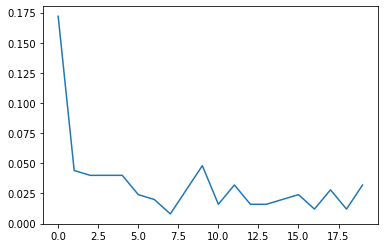

In [177]:
plt.plot(average_non_valid)

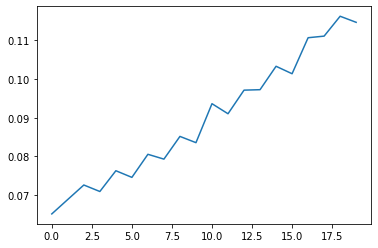

In [178]:
plt.plot(average_loss)

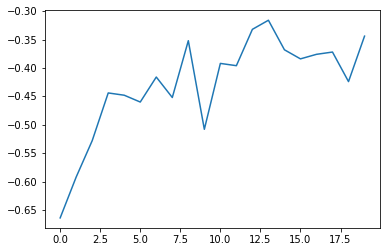

In [179]:
plt.plot(average_reward)